In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
#from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
#from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score


In [2]:
# read data with user observations
data = pd.read_csv('data/weather_data_with_user_text_new_observer.csv')
data['date'] = pd.to_datetime(data['date'])

# Split the original data into two parts
train = data[data['date'] <= '1995-09-30']
test = data[data['date'] > '1995-09-30']

print(data.shape, train.shape, test.shape)


(12418, 6) (5478, 6) (6940, 6)


In [3]:
train = train.copy()
test = test.copy()

def categorize_precipitation(prcp):
    if prcp >= 11.4:
        return 'wet'
    elif prcp >= 4 and prcp < 11.4:
        return 'normal'
    else:
        return 'dry'

# create a new label column. True label of the sample
train['weather_label'] = train['prcp(mm/day)'].apply(categorize_precipitation)
test['weather_label'] = test['prcp(mm/day)'].apply(categorize_precipitation)

nlp_data_train = train[['user_data', 'weather_label']]
nlp_data_test = test[['user_data', 'weather_label']]

print('labels count in train data\n\n',nlp_data_train[['weather_label']].value_counts())
print('\nlabels count in test data\n\n',nlp_data_test[['weather_label']].value_counts())

labels count in train data

 weather_label
dry              4144
normal            813
wet               521
dtype: int64

labels count in test data

 weather_label
dry              5164
normal           1053
wet               723
dtype: int64


In [4]:
nlp_data_train

,user_data,weather_label
0,Not a drop of rain today; it feels like the ar...,dry
1,A decent rainfall that left the ground well-so...,dry
2,"It rained quite heavily, leaving deep puddles ...",normal
3,"It rained quite heavily, leaving deep puddles ...",wet
4,Some steady rain brought a refreshing feel to ...,dry
...,...,...
5473,Enough rain fell to give the plants a good dri...,dry
5474,A few sprinkles were enough to dampen the eart...,dry
5475,"A strong rainfall today, making the landscape ...",normal
5476,Not a drop of rain today; it feels like the ar...,dry


In [5]:
nlp_data_train = nlp_data_train.copy()
nlp_data_test = nlp_data_test.copy()

# Split the original training data into train and test sets. This will used to train the ML models. only use original training data here
X_train = nlp_data_train['user_data']
X_test = nlp_data_test['user_data']
Y_train = nlp_data_train['weather_label']
Y_test = nlp_data_test['weather_label']

# Encode labels
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)  # dry -> 0, normal -> 1, wet -> 2
Y_test = encoder.transform(Y_test)

## Logistic regresion

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'classifier__C': 1, 'classifier__max_iter': 150, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'tfidf__max_features': 100, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}
Best Cross-Validation Accuracy: 0.7034412193012232

Train Accuracy: 0.7056149191974953

Test Accuracy: 0.884149855907781

Test balanced Accuracy: 0.7097937231584939

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5164
           1       0.59      0.83      0.69      1053
           2       0.54      0.33      0.41       723

    accuracy                           0.88      6940
   macro avg       0.71      0.71      0.69      6940
weighted avg       0.89      0.88      0.88      6940



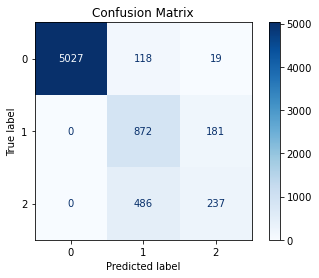

In [6]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression())
])

# hyperparameters
param_grid = {
    'tfidf__max_features': [10, 50, 100],              
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],      
    'tfidf__stop_words': [None, 'english'],   
    'classifier__C': [0.1, 1, 10, 100],                     
    'classifier__penalty': ['l2'],                          
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__max_iter': [150, 500]
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred))
print("\nTest balanced Accuracy:", balanced_accuracy_score(Y_test, y_pred))

print("\nClassification Report:\n", classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## KNN classifier

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters: {'classifier__n_neighbors': 8, 'classifier__weights': 'distance', 'tfidf__max_features': 100, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Best Cross-Validation Accuracy: 0.6876186981496366

Train Accuracy: 0.7111212506523645

Test Accuracy: 0.8717579250720461

Test balanced Accuracy: 0.6944714471952017

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      5164
           1       0.58      0.73      0.64      1053
           2       0.46      0.39      0.42       723

    accuracy                           0.87      6940
   macro avg       0.68      0.69      0.68      6940
weighted avg       0.88      0.87      0.87      6940



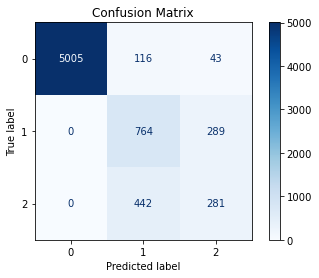

In [7]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'tfidf__max_features': [10, 50, 100],              
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],       
    'tfidf__stop_words': [None, 'english'],              
    'classifier__n_neighbors': [2,4,5,8,10],                     
    'classifier__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred))
print("\nTest balanced Accuracy:", balanced_accuracy_score(Y_test, y_pred))

print("\nClassification Report:\n", classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## Random forest

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__n_estimators': 75, 'tfidf__max_features': 100, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Best Cross-Validation Accuracy: 0.7139399515518301

Train Accuracy: 0.7433549703024208

Test Accuracy: 0.8698847262247839

Test balanced Accuracy: 0.707496394443461

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5164
           1       0.60      0.54      0.57      1053
           2       0.45      0.61      0.52       723

    accuracy                           0.87      6940
   macro avg       0.69      0.71      0.69      6940
weighted avg       0.88      0.87      0.87      6940



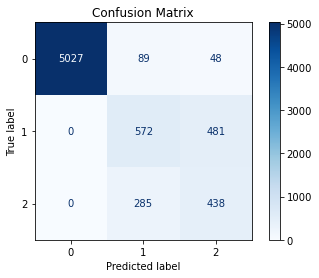

In [8]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'tfidf__max_features': [10, 50, 100],             
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],     
    'tfidf__stop_words': [None, 'english'],       
    'classifier__n_estimators': [20, 50, 75, 100],                     
    'classifier__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred))
print("\nTest balanced Accuracy:", balanced_accuracy_score(Y_test, y_pred))

print("\nClassification Report:\n", classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## XGBoost

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\smpwi\conda\envs\rrmpg\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 75, 'classifier__objective': 'multi:softmax', 'tfidf__max_features': 100, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Best Cross-Validation Accuracy: 0.6998237333763073

Train Accuracy: 0.7162301693039311

Test Accuracy: 0.8827089337175793

Test balanced Accuracy: 0.7073505948509119

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5164
           1       0.59      0.81      0.68      1053
           2       0.53      0.33      0.41       723

    accuracy                           0.88      6940
   macro avg   

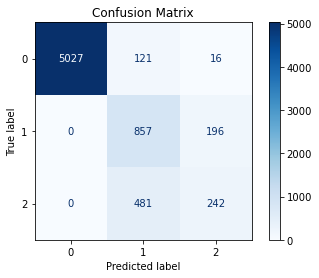

In [9]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier())
])

param_grid = {
    'tfidf__max_features': [10, 50, 100],              
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],      
    'tfidf__stop_words': [None, 'english'],           
    'classifier__n_estimators': [20, 50, 75, 100],                    
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.001],
    'classifier__objective': ['multi:softmax']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))


y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred))
print("\nTest balanced Accuracy:", balanced_accuracy_score(Y_test, y_pred))

print("\nClassification Report:\n", classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


## MLP classifier

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\smpwi\conda\envs\rrmpg\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best Parameters: {'classifier__hidden_layer_sizes': (64,), 'classifier__max_iter': 100, 'tfidf__max_features': 50, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}
Best Cross-Validation Accuracy: 0.7058416463880853

Train Accuracy: 0.7191182979932794

Test Accuracy: 0.8809798270893372

Test balanced Accuracy: 0.7032629522201618

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5164
           1       0.59      0.80      0.68      1053
           2       0.51      0.33      0.40       723

    accuracy                           0.88      6940
   macro avg       0.70      0.70      0.69      6940
weighted avg       0.89      0.88      0.88      6940



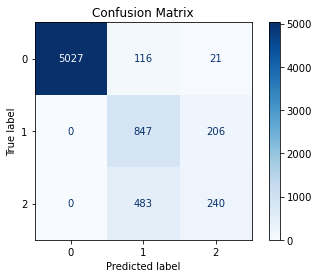

In [10]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', MLPClassifier())
])

param_grid = {
    'tfidf__max_features': [10, 50, 100],              
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],       
    'tfidf__stop_words': [None, 'english'],           
    'classifier__hidden_layer_sizes': [(32,16), (32,), (64,32), (64,)],                     
    'classifier__max_iter': [100, 500, 1000, 10000]
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", accuracy_score(Y_test, y_pred))
print("\nTest balanced Accuracy:", balanced_accuracy_score(Y_test, y_pred))

print("\nClassification Report:\n", classification_report(Y_test, y_pred))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
